# Deep Residual Network

### https://arxiv.org/abs/1512.03385
### http://torch.ch/blog/2016/02/04/resnets.html

In [1]:
import tensorflow as tf
print(tf.__version__)

2.3.1


In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, AveragePooling2D, \
                                    Dropout, Add, Input, ZeroPadding2D, Dense, Flatten

import matplotlib.pyplot as plt
import numpy as np
import cv2

# CIFAR 10 Dataset

Load the CIFAR-10 dataset which contains 50K 32x32x3 training images and 10K 32x32x3 testing images. In the cell below the `cifar10` class in `tf.keras.datasets` has been used to load the dataset. 

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

print('Training dataset: input {} shape; output {} shape'.format(x_train.shape, y_train.shape))
print('Test dataset:     input {} shape; output {} shape'.format(x_test.shape, y_test.shape))


Training dataset: input (50000, 32, 32, 3) shape; output (50000, 10) shape
Test dataset:     input (10000, 32, 32, 3) shape; output (10000, 10) shape


## Use `ImageDataGenerator`

ImageDataGenerator is used to consume the training data and produce batches from augmented dataset.

In [16]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=20,
                                                                width_shift_range=0.2,
                                                                height_shift_range=0.2,
                                                                horizontal_flip=True)

img_batch = next(train_datagen.flow(x_train, y_train, shuffle=True, batch_size=32))

Plotting a single batch of 32 images

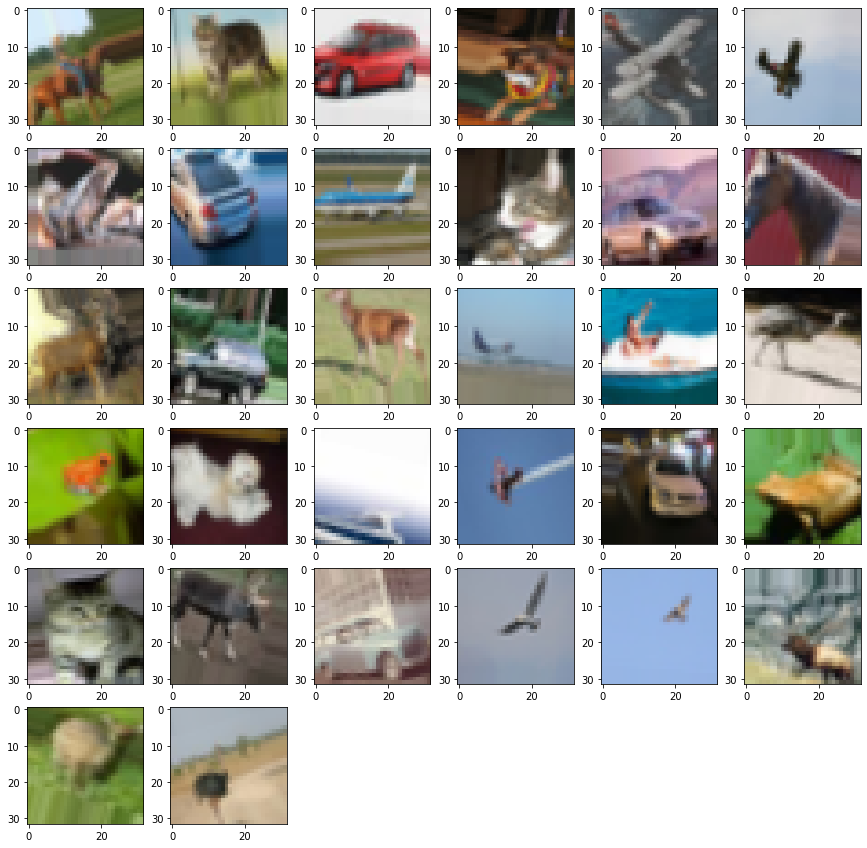

In [5]:
fig = plt.figure(figsize=(15,15))
for i in range(len(img_batch[1])):
    plt.subplot(6,6,i+1)
    plt.imshow(np.array(img_batch[0][i], dtype=np.uint8))
    

# Defining the Model and its Components

In this implementation I am attempting to implement and train a ResNet-50 model. The Resnet-50 block is based on the Bottlenect architecture [1], where the main path of residual block is made out of three conv layers (1x1 conv layer followed by 3x3 conv layer and 1x1 conv layer) in conjunction with the skip layer. The skip connection is implemented for two cases: 
1. when the output shape of the main block is the same shape as the input then the skip connection is just an identity mapping, else, 
2. when the ouput shape of the main branch has been downsampled using a the 1st 1x1 conv layer with a stride of 2 then the skip connection is implemented as a 1x1 conv layer with a stride of 2, hence producing activation maps of equal shape to be operated upon by `add` operator.


[1] K. He, X. Zhang, S. Ren, J. Sun, "Deep Residual Learning for Image Recognition", CoRR, 2015.

In [6]:
class bottleneck_residual_block(Layer):
    '''
    The bottleneck residual layer for 50, 101, and 152 layer networks
    '''
    def __init__(self, filters, kernel_size=3, 
                 block_id=0, downsample_flag=False,
                 use_1x1_conv_skip=False, **kwargs):
        
        f1, f2, f3 = filters
        block_name = "residual_block_" + str(block_id)
        super(bottleneck_residual_block, self).__init__(name=block_name, **kwargs)
        
        stride = 2 if downsample_flag else 1
        self.downsample_flag = downsample_flag
        self.use_1x1_conv_skip = use_1x1_conv_skip
        
        # 1x1 conv to receive the input into main branch
        self.main_conv1 = Conv2D(filters=f1, 
                       kernel_size=(1, 1), 
                       strides = (1, 1),
                       padding='SAME',
                       name=block_name+"_main_1",
                       kernel_initializer='he_normal')
        # 3x3 convolutions will perform downsampling if needed
        self.main_conv2 = Conv2D(filters=f2, 
                       kernel_size=(kernel_size, kernel_size), 
                       strides = (stride, stride),
                       padding='SAME',
                       name=block_name+"_main_2",
                       kernel_initializer='he_normal')
        # 1x1 conv in main branch to increase filter size
        self.main_conv3 = Conv2D(filters=f3, 
                       kernel_size=(1, 1), 
                       strides = (1, 1),
                       padding='SAME',
                       name=block_name+"_main_3",
                       kernel_initializer='he_normal')

        self.main_bn1 = BatchNormalization()
        self.main_bn2 = BatchNormalization()
        self.main_bn3 = BatchNormalization()
        
        # depending on downsample flag either the skip conv layer
        # will downsample using a stride of 2 or keep the same 
        # shape using stride of 1, but in any case it will match the
        # output shape of main branch
           
        if downsample_flag or use_1x1_conv_skip:
            self.skip_conv1 = Conv2D(filters=f3, 
                       kernel_size=(1, 1), 
                       strides = (stride, stride),
                       padding='SAME',
                       name=block_name+"_skip_downsample_1",
                       kernel_initializer='he_normal')
            self.skip_bn1 = BatchNormalization()
       
        self.add = Add()
        
    def call(self, inputs):
        
        # bottleneck design (Figure 5) He et. al.
        x = self.main_conv1(inputs)
        x = self.main_bn1(x)
        x = tf.nn.relu(x)
        
        x = self.main_conv2(x)
        x = self.main_bn2(x)
        x = tf.nn.relu(x)
        
        x = self.main_conv3(x)
        x = self.main_bn3(x)
        
        if self.downsample_flag or self.use_1x1_conv_skip:
            skip_output = self.skip_conv1(inputs)
            skip_output = self.skip_bn1(skip_output)
        else:
            skip_output = inputs
        
        x = self.add([x, skip_output])

        out = tf.nn.relu(x)
        
        return out
            

Now we test the custom layer with some dummy inputs to make sure that our intended shapes are achieved and there is no errors in the definition of custom layer above. In the cell below I have tested residual block with both identity and downsampling skip connection functionality and the block seems to perform as expected (as far as the shape of input and output goes).

In [7]:
# testign the convolutional functionality of residual layer  
conv_block = bottleneck_residual_block([64, 64, 256], downsample_flag=True)
input_val = tf.constant(tf.zeros((1, 224, 224, 32)))
output_val_conv = conv_block(input_val)
print('Conv Block: Input Shape: {} --> Output Shape: {}\n'.format(input_val.shape, output_val_conv.shape))

# testing the identity block functionality of residual layer
iden_block = bottleneck_residual_block([64, 64, 256], downsample_flag=False)
output_val_ident = iden_block(output_val_conv)
print('Ident Block: Input Shape: {} --> Output Shape: {}\n'.format(output_val_conv.shape, output_val_ident.shape))


Conv Block: Input Shape: (1, 224, 224, 32) --> Output Shape: (1, 112, 112, 256)

Ident Block: Input Shape: (1, 112, 112, 256) --> Output Shape: (1, 112, 112, 256)



Time to assemble the complete network. 

In [8]:
def ResNet50(input_val, num_classes):
    
    input_tens = Input(shape=(input_val.shape[1], input_val.shape[2], input_val.shape[3]))
    
    x = tf.image.resize_with_pad(input_tens, 64, 64)
    
    x = ZeroPadding2D(padding=(3,3))(x)

    x = Conv2D(filters=64, kernel_size=(7, 7), strides = (2, 2), padding='VALID',
                       kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    
    # first residual block x3
    x = bottleneck_residual_block([64,64,256], block_id="2_1", use_1x1_conv_skip=True)(x)
    x = bottleneck_residual_block([64,64,256], block_id="2_2")(x)
    x = bottleneck_residual_block([64,64,256], block_id="2_3")(x)

    # second residual block x4
    x = bottleneck_residual_block([128,128,512], block_id="3_1", downsample_flag=True)(x)
    x = bottleneck_residual_block([128,128,512], block_id="3_2")(x)
    x = bottleneck_residual_block([128,128,512], block_id="3_3")(x)
    x = bottleneck_residual_block([128,128,512], block_id="3_4")(x)
    
    # third residual block x6
    x = bottleneck_residual_block([256,256,1024], block_id="4_1", downsample_flag=True)(x)
    x = bottleneck_residual_block([256,256,1024], block_id="4_2")(x)
    x = bottleneck_residual_block([256,256,1024], block_id="4_3")(x)
    x = bottleneck_residual_block([256,256,1024], block_id="4_4")(x)
    x = bottleneck_residual_block([256,256,1024], block_id="4_5")(x)
    x = bottleneck_residual_block([256,256,1024], block_id="4_6")(x)
    
    # fourth residual block x3
    x = bottleneck_residual_block([512,512,2048], block_id="5_1", downsample_flag=True)(x)
    x = bottleneck_residual_block([512,512,2048], block_id="5_2")(x)
    x = bottleneck_residual_block([512,512,2048], block_id="5_3")(x)
    
    x = AveragePooling2D(pool_size=(2, 2))(x)
    
    x = Flatten()(x)
    
    x = Dense(units=num_classes, activation='softmax')(x)
    
    model = Model(inputs=input_tens, outputs=x)
    
    return model

Lets look at the model summary and model connectivity. Now that the residual layer has been implemented using subclassing of layers class, the connectivity within the custo layer cannot be plotted by the keras model plotting utility. 

The residual layer could have been implemented using functional API and then the keras model plotting utility would have shown the DAG in full glory. For this excercise I wanted to get my hands on to subclassing approach.

In [9]:
input_val = tf.constant(tf.zeros((1, 32, 32, 3)))
model = ResNet50(input_val, 10)

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
tf_op_layer_ResizeBilinear ( [(None, 64, 64, 3)]       0         
_________________________________________________________________
tf_op_layer_Pad (TensorFlowO [(None, 64, 64, 3)]       0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 70, 70, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 64)        9472      
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)       

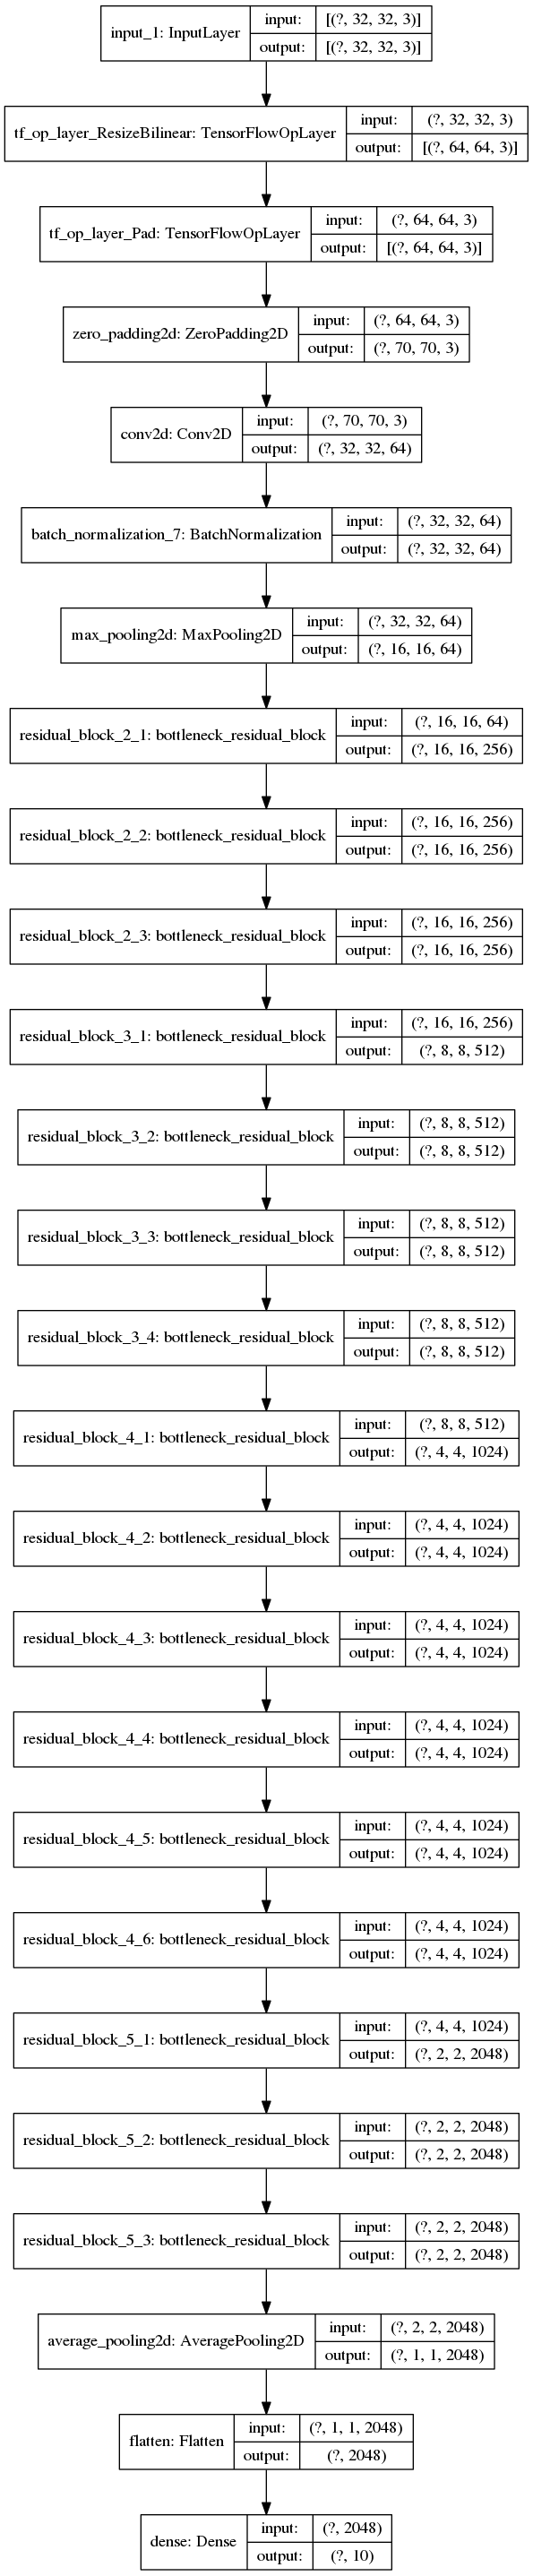

In [10]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

# Training

To prepare the model for training the very first step is to compile the model using an optimizer and a loss function at the very minimum. Here I have used Adam optimizer and Categorical Cross Entropy as the specific options for optimizer and loss respectively. In addition to `Accuracy` has been used as a performance metric.

In [11]:
loss = tf.keras.losses.CategoricalCrossentropy()
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

To keep tabs on the training I am using two callbacksfunctions to throttle the learning rate using  `ReduceLROnPlateau` and stop the training if validation loss stops decreasing using `EarlyStopping`.

In [12]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, 
                                                 patience=2, min_lr=0.00001)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(train_datagen.flow(x_train, y_train, shuffle=True, batch_size=64), 
                    epochs=64,
                    validation_data=train_datagen.flow(x_test, y_test, shuffle=True, batch_size=64),
                    callbacks=[reduce_lr, early_stopping])

Epoch 1/64
782/782 [==============================] - 396s 507ms/step - loss: 1.9990 - accuracy: 0.3387 - val_loss: 3.9123 - val_accuracy: 0.3090
Epoch 2/64
782/782 [==============================] - 393s 503ms/step - loss: 1.5521 - accuracy: 0.4489 - val_loss: 1.9510 - val_accuracy: 0.3564
Epoch 3/64
782/782 [==============================] - 395s 505ms/step - loss: 1.3541 - accuracy: 0.5183 - val_loss: 1.6952 - val_accuracy: 0.4517
Epoch 4/64
782/782 [==============================] - 393s 503ms/step - loss: 1.2799 - accuracy: 0.5449 - val_loss: 1.7568 - val_accuracy: 0.4264
Epoch 5/64
782/782 [==============================] - 391s 500ms/step - loss: 1.1875 - accuracy: 0.5852 - val_loss: 2.3574 - val_accuracy: 0.3548
Epoch 6/64
782/782 [==============================] - 395s 505ms/step - loss: 0.9438 - accuracy: 0.6688 - val_loss: 0.9527 - val_accuracy: 0.6654
Epoch 7/64
782/782 [==============================] - 388s 496ms/step - loss: 0.8963 - accuracy: 0.6827 - val_loss: 0.8647 -

Lets look at some training statistics.

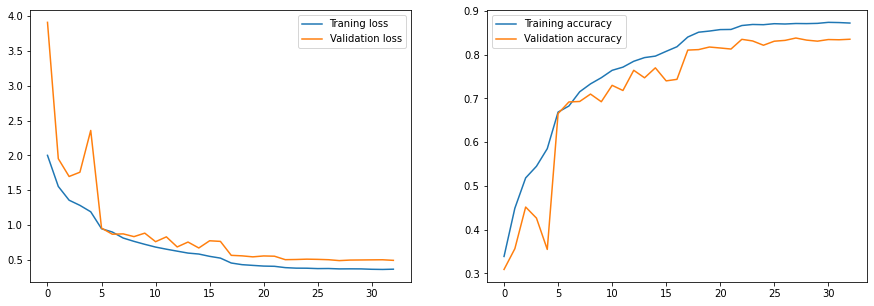

In [13]:
loss_hst = history.history['loss']
val_loss_hst = history.history['val_loss']
accuracy_hst = history.history['accuracy']
val_accuracy_hst = history.history['val_accuracy']

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(loss_hst)
plt.plot(val_loss_hst)
plt.legend(['Traning loss', 'Validation loss'])

plt.subplot(1,2,2)
plt.plot(accuracy_hst)
plt.plot(val_accuracy_hst)
plt.legend(['Training accuracy', 'Validation accuracy'])

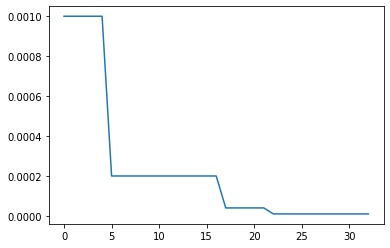

In [14]:
plt.plot(history.history['lr'])

Saving the model graph and weights for subsequent use.

In [15]:
model.save('saved_model/resnet50')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: saved_mode/resnet50/assets
